In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
#from utils_unet_resunet import *
from ops import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
from model.models import UNET
from model.losses import WBCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import os
import gc

## Parameters

In [3]:
img_path = 'imgs' 
n_opt_layer = 26 #number of OPT layers, used to split de input data between OPT and SAR

number_class = 3
weights = [0.2, 0.8, 0]
times=5
exp = 2

overlap = 0.7
patch_size = 128
batch_size = 32

img_type = 'SAR'
cond = 'no_cloudy'
test_cond = 'no_cloudy'

nb_filters = [32, 64, 128]

method = 'unet'

## Load file

In [4]:
image_array = np.load(os.path.join(img_path, f'fus_stack_{cond}.npy'))

if img_type == 'OPT':
    image_array = image_array[:, :, :n_opt_layer]
    
if img_type == 'SAR':
    image_array = image_array[:, :, n_opt_layer:]
    
print('Image stack:', image_array.shape)

final_mask1 = np.load(os.path.join(img_path, 'final_mask1.npy'))
print('Labels stack:', final_mask1.shape)
h_, w_, channels = image_array.shape

Image stack: (17730, 9203, 4)
Labels stack: (17730, 9203)


## Create tiles mask

mask:  (17730, 9203)
image stack:  (17730, 9203, 4)
ref : (17730, 9203)


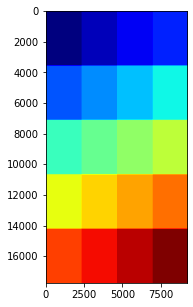

In [5]:
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
plt.figure(figsize=(10,5))
plt.imshow(mask_tiles, cmap='jet')

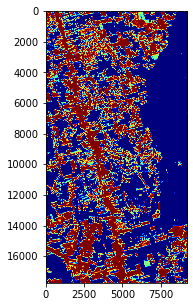

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

## Define tiles for training, validation and tests.

In [7]:
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

#mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
#for ts_ in tiles_ts:
#    mask_amazon_ts[mask_tiles == ts_] = 1

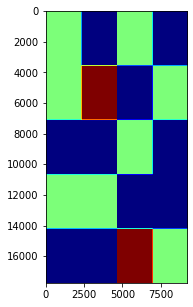

In [8]:
plt.figure(figsize=(10,5))
plt.imshow(mask_tr_val, cmap='jet')

## Create index image to extract patches without overcharge the system.

In [9]:
im_idx = create_idx_image(final_mask1)

patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size) #índice do pixel de cada patch
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size) #1 se pixel for de treinamento 2 se for val
del im_idx

## Select training, validation and test patches, keeping a minumum of 2% of deforestation pixels, to minimize the imbalance.

In [10]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2)) #extrai apenas idx dos patches com todos os valores == 1 (train)
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2)) #extrai apenas idx dos patches com todos os valores == 2 (val)
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   41812 Number of validation patches 10260


In [11]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val
gc.collect()

(2991, 128, 128) (836, 128, 128)


0

In [12]:
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

Y_train = np.zeros_like(X_train)
Y_valid = np.zeros_like(X_valid)

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), Y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), Y_valid,
                              batch_size=batch_size,
                              shuffle=False)


In [13]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, _ = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

In [14]:
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)

In [15]:
path_exp = os.path.join(img_path, 'experiments', f'exp_{exp}')
path_models = os.path.join(img_path, 'models')
path_maps = os.path.join(img_path, 'pred_maps')

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [16]:
# Define model
input_shape = (patch_size, patch_size, channels)



model = UNET(nb_filters, number_class)

In [17]:
# Parameters of the model

adam = Adam(lr = 1e-3 , beta_1=0.9)
#loss = weighted_categorical_crossentropy(weights)
loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [18]:
metrics_all = []

for tm in range(0,times):
    
    print('time: ', tm)
    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-3 , beta_1=0.9)
    loss = WBCE(weights = weights)
    model = UNET(nb_filters, number_class)
    model.build((None,)+input_shape)
    model.summary()
    
    # train the model
    start_training = time.time()
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    checkpoint = ModelCheckpoint(os.path.join(path_models, f'{method}_{tm}.h5'), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    callbacks_list = [earlystop, checkpoint]
    history = model.fit(train_gen_crops,
                              steps_per_epoch=3*(len(X_train)//train_gen.batch_size),
                              validation_data=valid_gen_crops,
                              validation_steps=3*(len(X_valid)//valid_gen.batch_size),
                              epochs=100,
                              callbacks=callbacks_list)
    
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history


time:  0
Model: "unet_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unet_encoder (UNET_Encoder)  multiple                  536288    
_________________________________________________________________
unet_decoder (UNET_Decoder)  multiple                  332000    
_________________________________________________________________
classifier (Classifier)      multiple                  195       
Total params: 868,483
Trainable params: 868,483
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
279/279 [==============================] - 16s 45ms/step - loss: 0.1527 - accuracy: 0.6159 - val_loss: 0.1230 - val_accuracy: 0.7434

Epoch 00001: val_loss improved from inf to 0.12303, saving model to imgs\models\unet_0.h5
Epoch 2/100
279/279 [==============================] - 12s 41ms/step - loss: 0.1068 - accuracy: 0.7340 - val_loss: 0.1220 - val_accuracy: 0

279/279 [==============================] - 20s 68ms/step - loss: 0.1506 - accuracy: 0.6198 - val_loss: 0.1213 - val_accuracy: 0.7454

Epoch 00001: val_loss improved from inf to 0.12132, saving model to imgs\models\unet_2.h5
Epoch 2/100
279/279 [==============================] - 19s 68ms/step - loss: 0.1095 - accuracy: 0.7315 - val_loss: 0.1073 - val_accuracy: 0.7664

Epoch 00002: val_loss improved from 0.12132 to 0.10726, saving model to imgs\models\unet_2.h5
Epoch 3/100
279/279 [==============================] - 19s 69ms/step - loss: 0.0970 - accuracy: 0.7560 - val_loss: 0.1054 - val_accuracy: 0.7763

Epoch 00003: val_loss improved from 0.10726 to 0.10536, saving model to imgs\models\unet_2.h5
Epoch 4/100
279/279 [==============================] - 19s 67ms/step - loss: 0.0902 - accuracy: 0.7722 - val_loss: 0.1050 - val_accuracy: 0.7807

Epoch 00004: val_loss improved from 0.10536 to 0.10502, saving model to imgs\models\unet_2.h5
Epoch 5/100
279/279 [==============================] - 1


Epoch 00004: val_loss did not improve from 0.10828
Epoch 5/100
279/279 [==============================] - 18s 66ms/step - loss: 0.0863 - accuracy: 0.7799 - val_loss: 0.1198 - val_accuracy: 0.7660

Epoch 00005: val_loss did not improve from 0.10828
Epoch 6/100
279/279 [==============================] - 19s 67ms/step - loss: 0.0806 - accuracy: 0.7897 - val_loss: 0.1228 - val_accuracy: 0.7554

Epoch 00006: val_loss did not improve from 0.10828
Epoch 7/100
279/279 [==============================] - 19s 67ms/step - loss: 0.0790 - accuracy: 0.7943 - val_loss: 0.1168 - val_accuracy: 0.7662

Epoch 00007: val_loss did not improve from 0.10828
Epoch 8/100
279/279 [==============================] - 19s 67ms/step - loss: 0.0705 - accuracy: 0.8088 - val_loss: 0.1230 - val_accuracy: 0.7593

Epoch 00008: val_loss did not improve from 0.10828
Epoch 9/100
279/279 [==============================] - 19s 69ms/step - loss: 0.0665 - accuracy: 0.8159 - val_loss: 0.1323 - val_accuracy: 0.7390

Epoch 00009: v